In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pymc3 as pm

In [3]:
cost_living = pd.read_csv('clean_data/cost_of_living.csv')
#cost of living index throughout the world highlighting the US.
data4 = cost_living.copy()
data4 = data4[data4.country == ' United States']
data4.head()

,country,state,city,cost_of_living,rank_world
420,United States,AK,Anchorage,93.19,16
421,United States,AL,Birmingham,71.87,126
422,United States,AL,Huntsville,59.80,285
423,United States,AR,Fayetteville,64.84,228
424,United States,AR,Little Rock,60.31,281


In [4]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) /n

    return x, y

In [5]:
us_mean = np.mean(data4.cost_of_living)
us_std = np.std(data4.cost_of_living)

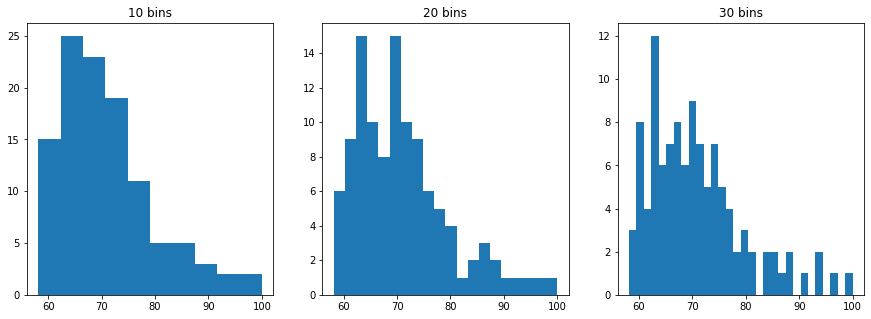

In [7]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
_ = plt.hist(data4.cost_of_living, bins=10)
_ = plt.title('10 bins')
plt.subplot(1,3,2)
_ = plt.hist(data4.cost_of_living, bins=20)
_ = plt.title('20 bins')
plt.subplot(1,3,3)
_ = plt.hist(data4.cost_of_living, bins=30)
_ = plt.title('30 bins')

In [50]:
world_mean = np.mean(cost_living.cost_of_living)
world_std = np.std(cost_living.cost_of_living)

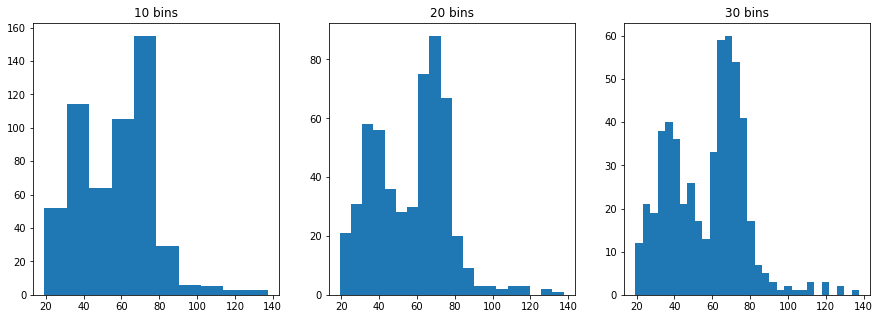

In [8]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
_ = plt.hist(cost_living.cost_of_living, bins=10)
_ = plt.title('10 bins')
plt.subplot(1,3,2)
_ = plt.hist(cost_living.cost_of_living, bins=20)
_ = plt.title('20 bins')
plt.subplot(1,3,3)
_ = plt.hist(cost_living.cost_of_living, bins=30)
_ = plt.title('30 bins')

plt.show()

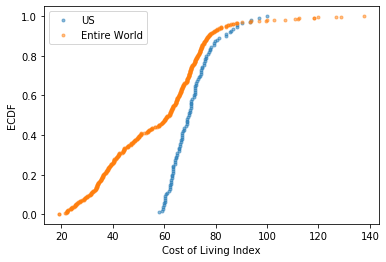

In [57]:
x_us, y_us = ecdf(data4.cost_of_living)
x_world, y_world = ecdf(cost_living.cost_of_living)
_ = plt.plot(x_us, y_us, marker='.', linestyle='none', alpha=0.5)
_ = plt.plot(x_world, y_world, marker='.', linestyle='none', alpha=0.5)
_ = plt.legend(['US', 'Entire World'])
_ = plt.xlabel('Cost of Living Index')
_ = plt.ylabel('ECDF')

plt.show()


After observing various renditions of the distributions, we can assume they are bimodal and not normal. The distributions appear to have exponential characteristics, so Bayesian inference will work best for determining the population mean.

In [65]:
# determine the mean cost of living in the us with its uncertainty
us_sample = data4.cost_of_living

# compute summary statistics for the US sample
observed_us_mean = np.mean(us_sample)
observed_us_stdev = np.std(us_sample, ddof=1) # s not sigma

# complare sample STDEV to Central Limit Theorm
clt_us_stdev = np.std(us_sample)/np.sqrt(len(us_sample))

# Note: distribution is not normal, so results will not match
print(observed_us_stdev.round(3), clt_us_stdev.round(3))


8.811 0.836


In [67]:
# calculate population mean for cost of living from the us_sample with Frequentist inference
standard_err = observed_us_stdev /np.sqrt(len(us_sample))
standard_err

0.8400836527150295

In [70]:
crit_val = norm.ppf(0.975)
print('z-value: ' + str(crit_val.round(3)))

z-value: 1.96


In [71]:
marg_err = crit_val * standard_err
print('Margin of Error: ' + str(marg_err.round(3)))

Margin of Error: 1.647


In [74]:
# compute 95% confidence interval
int_min = observed_us_mean - marg_err
int_max = observed_us_mean + marg_err

conf_int = (int_min.round(3), int_max.round(3))
conf_int

((69.26, 72.553), 70.90645454545455)

In [ ]:
# calculate population mean from cost of living from the us_sample with Bootstrap inference

In [75]:
def bootstrap_replicate_1d(data, func):
    """Draw a single bootstrap replicate"""
    return func(np.random.choice(data, size=len(data)))

In [76]:
def draw_bs_reps(data, func, size=1):
    """Draw many bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

In [82]:
# generate 10,000 bootstrap replicates of the mean
N_reps = 10000
bs_replicates = draw_bs_reps(us_sample, np.mean, N_reps)

# compute standard error of the mean
sem = np.std(us_sample) / np.sqrt(len(us_sample))


70.905 70.906


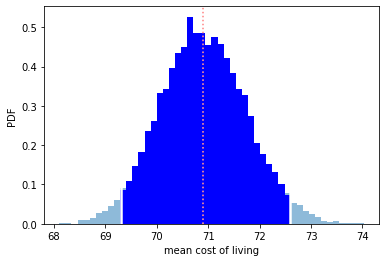

In [136]:
def percentile_p(arr, p):
    """return a tuple of the lower and upper bounds of a p_% confindence interval"""
    ends = 100 - p
    left = ends/2
    right = 100 - left
    return np.percentile(arr, [left, right])

conf_min, conf_max = percentile_p(bs_replicates, 95)
conf_range = bs_replicates[(bs_replicates >= conf_min) & (bs_replicates <= conf_max)]

# plot distribution of bootstrap replicates
_ , bins, _ = plt.hist(bs_replicates, bins=50, density=True, alpha=0.5)
_ = plt.hist(conf_range, bins=bins, density=True, alpha=1, color='b')
_ = plt.xlabel('mean cost of living')
_ = plt.ylabel('PDF')


_ = plt.axvline(conf_min, color='w', linestyle='-', linewidth=2.5)
_ = plt.axvline(conf_max, color='w', linestyle='-', linewidth=2.5)
_ = plt.axvline(np.mean(bs_replicates), color='w', linestyle=':')
_ = plt.axvline(observed_us_mean, color='r', alpha=0.5, linestyle=':')
print(np.mean(bs_replicates).round(3), observed_us_mean.round(3))
plt.show()

In [141]:
# Now with Bayesian Inference because the original distribution looks bimodal

In [139]:
us_sample.head()

420    93.19
421    71.87
422    59.80
423    64.84
424    60.31
Name: cost_of_living, dtype: float64

In [140]:
n_us_sample = len(us_sample)

In [142]:
# intial parameter estimation
alpha_est = np.mean(us_sample)**2 / np.var(us_sample)
beta_est = np.var(us_sample) / np.mean(us_sample)
alpha_est, beta_est

(65.35818378248898, 1.0848902224919548)

In [145]:
# create rate estimate 
rate_est = 1/beta_est
alpha_est, rate_est

(65.35818378248898, 0.9217522466955551)

In [147]:
# create a pymc3 model

with pm.Model() as model:
    N_draws = 10000
    
    # use exponential prior for alpha
    alpha_ = pm.Exponential('alpha_', 1/alpha_est)
    
    # use exponential prior for rate (1 / beta)
    rate_ = pm.Exponential('rate_', 1/rate_est)
    
    # create gamma distribution
    us_sample_gam_dist = pm.Gamma('us_sample_gam_dist', alpha=alpha_, beta=rate_, observed=us_sample)
    
    # perfrom 10000 draws
    trace = pm.sample(N_draws)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rate_, alpha_]
Sampling 2 chains: 100%|██████████| 21000/21000 [01:36<00:00, 217.49draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [151]:
# calculate the 95% credible interval for alpha & beta
with model:
    alpha_ci = percentile_p(trace['alpha_'], 95)
    beta_ci = percentile_p(1/trace['rate_'], 95)
alpha_ci

array([52.12490784, 87.9571305 ])

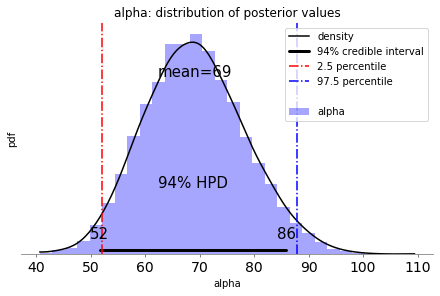

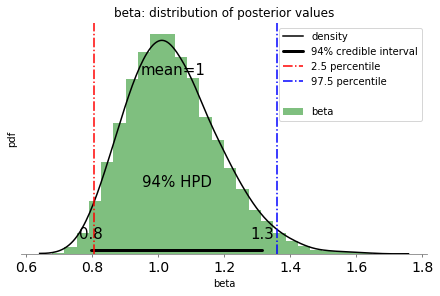

In [152]:

# plot posterior values of alpha & beta


_ = pm.plots.plot_posterior(data=trace['alpha_'], color='k')
_ = plt.hist(trace['alpha_'], bins=30, color='blue', alpha=0.35, density=True)
l1 , r1 = alpha_ci
_ = plt.axvline(l1, color='red', linestyle='-.')
_ = plt.axvline(r1, color='blue', linestyle='-.')
_ = plt.legend(['density', '94% credible interval', '2.5 percentile','97.5 percentile','','alpha'])
_ = plt.title('alpha: distribution of posterior values')
_ = plt.ylabel('pdf')
_ = plt.xlabel('alpha')


_ = pm.plots.plot_posterior(data=1/trace['rate_'], color='k')
_ = plt.hist(1/trace['rate_'], bins=30, color='g', alpha=0.5, density=True)
l2, r2 = beta_ci
_ = plt.axvline(l2, color='red', linestyle='-.')
_ = plt.axvline(r2, color='blue', linestyle='-.')
_ = plt.legend(['alpha', 'density', '95% credible interval'])
_ = plt.legend(['density', '94% credible interval', '2.5 percentile','97.5 percentile','','beta'])
_ = plt.title('beta: distribution of posterior values')
_ = plt.ylabel('pdf')
_ = plt.xlabel('beta')

plt.show()